# Another BaseLine Transformer model

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use Close values as a state vector though we can take same approch for finance data.
As feature is very limited, this would be a base line of Transformer.

Parameters:
- Input:  ohlc_df["close"].iloc[index: index+data_length] while observation_length
- Target: ohlc_df["close"].iloc[index + observation_length:index + observation_length + data_length]

## Data Preparation

In [1]:
import os
import pandas as pd

data_path = os.path.abspath('L:/data/fx/OANDA-Japan MT5 Live')
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath(f'{data_path}/mt5_USDJPY_min30.csv')

df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


## Define Dataset

In [2]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from tqdm import tqdm

In [3]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.base import Dataset
from fprocess import fprocess

In [172]:
import random

class MonoDataset(Dataset):
    key = "close"        

    def __init__(self, df, processes, column="close", data_length=30, observation_length:int=30, 
                 device=None, prediction_length=10, seed=1017, is_training = True, randomize=True):
        self.data_length = data_length
        device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super().__init__(df, [column], observation_length, device, processes, prediction_length, seed, is_training, randomize)            
        print("deleted", len(self.org_data) - len(self._data), "length of data by dropna")
        self._columns = column
                
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size                
            chunk_tgt = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                future_tgt = []
                # -1 for shift
                for bias in range(-1, self._prediction_length):
                    start_index = index + self.observation_length - self.data_length  + bias
                    stop_index = index + self.observation_length + bias
                    step_ndx = slice(start_index, stop_index)
                    future_tgt.append(self._data[self._columns].iloc[step_ndx].values.tolist())
                chunk_tgt.append(future_tgt)
            
            return torch.tensor(chunk_tgt, device=self.device, dtype=torch.float).transpose(0, 1)
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size
            chunk_src = []
            time_chunk_src = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                obs_src = []
                for bias in range(self.observation_length):
                    stop_index = index + bias
                    obs_ndx = slice(index - self.data_length + bias, stop_index)
                    obs_src.append(self._data[self._columns].iloc[obs_ndx].values.tolist())
                chunk_src.append(obs_src)
        
            return torch.tensor(chunk_src, device=self.device, dtype=torch.float).transpose(0, 1)
           
    def get_row_data(self, ndx):
        inputs = []
        # return (data_length + observation_length). It represents entire input data of (observation_length, data_length) shape
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self._data[index - self.data_length: index + self.observation_length]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self._data[index -self.data_length: index + self.observation_length]
        return inputs

    def _init_indicies(self, data, randomize, split_ratio=0.7):
        length = len(data) - self.observation_length -self.data_length - self._prediction_length
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        from_index = self.data_length
        to_index = int(length*split_ratio)
        self.train_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        from_index = int(length*split_ratio) + self.observation_length + self.data_length + self._prediction_length
        to_index = length
        self.val_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True
    
    def revert_prediction(self, values, ndx):
        r_data = values
        indices = self.get_actual_index(ndx)
        tgt_indices = []
        for __index in indices:
            # add observation_length to get the start index of prediction
            start_index = __index + self.observation_length - 2
            tgt_indices.append(start_index)
        indices = tgt_indices
        for r_index, process in enumerate(reversed(self.processes)):
            params = process.revert_params
            p_index = len(self.processes) - r_index -1
            # print("revert process:", process.kinds)
            if len(params) == 1:
                r_data = process.revert(r_data)
            else:
                params = {}
                if process.kinds == fprocess.MinMaxPreProcess.kinds:
                    r_data = process.revert(r_data)
                elif process.kinds == fprocess.SimpleColumnDiffPreProcess.kinds:
                    close_column = process.base_column
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [1]
                        base_processes = []
                        for base_process in processes:
                            if close_column in base_process.columns:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            raise Exception("Not implemented yet")
                    base_indices = [index - 1 for index in indices]
                    base_values = self.org_data[close_column].iloc[base_indices]
                    r_data = process.revert(r_data, base_value=base_values)
                elif process.kinds == fprocess.DiffPreProcess.kinds:
                    periods = process.periods
                    target_columns = process.columns
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [process.get_minimum_required_length()]
                        base_processes = []
                        for base_process in processes:
                            if len(set(target_columns) & set(base_process.columns)) > 0:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            required_length = max(required_length)
                            batch_base_indices = [index - required_length for index in indices]
                            batch_base_values = pd.DataFrame()
                            for index in batch_base_indices:
                                target_data = self.org_data[target_columns].iloc[index : index + required_length]
                                for base_process in base_processes:
                                    target_data = base_process(target_data)
                                batch_base_values = pd.concat([batch_base_values, target_data.iloc[-1:]], axis=0)
                            batch_base_values = batch_base_values.values.reshape(1, *batch_base_values.shape)
                        else:
                            base_indices = [index -2 for index in indices]
                            batch_base_values = self.org_data[target_columns].iloc[base_indices]
                    else:
                        # index[i] + obs_length - peridos for base value, then + periods as diff generate nan for periods
                        base_indices = indices
                        if periods > 1:
                            batch_base_values = None
                            for base_index in base_indices:
                                # as tgt value includes last value, plus 1
                                base_value = self.org_data[target_columns].iloc[base_index: base_index + self._prediction_length + 1].values
                                base_value  = base_value.reshape(base_value.shape[0], 1, base_value.shape[1])
                                if batch_base_values is None:
                                    batch_base_values = base_value
                                else:
                                    batch_base_values = np.concatenate([batch_base_values, base_value], axis=1)
                        else:
                            batch_base_values = self.org_data[target_columns].iloc[base_indices].values
                    r_data = process.revert(r_data, base_values=batch_base_values, discontinuity=True)
                else:
                    raise Exception(f"Not implemented: {process.kinds}")
        return r_data

In [5]:
close_column = "close"
columns = [close_column]

diff_p = fprocess.DiffPreProcess(columns=columns, periods=10)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = MonoDataset(df, processes=processes, column=close_column)

In [6]:
# check ds works and output expected shape
src, tgt = ds[: 16]
src.shape, tgt.shape

(torch.Size([30, 16, 30]), torch.Size([11, 16, 30]))

## Define Model

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05, batch_first=True):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        if batch_first:
            pe = pe.transpose(0, 1)
            self.forward = self.__fforward
        else:
            self.forward = self.__mforward
            
        self.register_buffer("pe", pe)

    def __mforward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])
    
    def __fforward(self, src, tgt):
        src_pos = src.size(1)
        tgt_pos = src_pos + tgt.size(1) - 1
        return self.dropout(src + self.pe[:, :src_pos, :]), self.dropout(tgt + self.pe[:, src_pos-1:tgt_pos, :])

In [8]:
class Seq2SeqTransformer(nn.Module):

    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        d_model: int, batch_first=True,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):

        super(Seq2SeqTransformer, self).__init__()
        self.args = {"num_decoder_layers": num_decoder_layers, "num_encoder_layers": num_decoder_layers, "d_model": d_model, "dim_feedforward": dim_feedforward, "dropout": dropout, "nhead": nhead}
        
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout, batch_first=batch_first)

        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=batch_first
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=batch_first
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):

        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        outs = self.output(outs)
        return outs

In [9]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model = model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src,
            tgt=input_tgt,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [10]:
def evaluate(model, ds, criterion, batch_size):
    
    model = model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src,
            tgt=input_tgt,
            mask_tgt=mask_tgt
        )

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [173]:
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 30
observation_length = 30
prediction_length = 10
close_column = "close"
columns = [close_column]

# log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns, periods=10)
ohlc_pre_process = [diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = MonoDataset(df, column=close_column, data_length=d_model, observation_length=observation_length, prediction_length=prediction_length, processes=processes)

deleted 10 length of data by dropna


In [48]:
model_name = "finance_basic_close_transformer"
model_version = 1

In [13]:
feature_size = 1
d_model=30
nhead = 3
dim_feedforward = 10
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.01

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model=d_model,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead,
    batch_first=False
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

d:\d_drive\workspace\stocknet_study\.venv312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
lr = 1e-3

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [32]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 2
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 1257/1257 [01:36<00:00, 13.03it/s]


[1/500] train loss: 0.0134606110, valid loss: 0.0026359256  36s] count: 0, **


100%|██████████| 1257/1257 [01:41<00:00, 12.33it/s]


[2/500] train loss: 0.0034242620, valid loss: 0.0015896876  42s] count: 0, **


100%|██████████| 1257/1257 [01:42<00:00, 12.30it/s]


[3/500] train loss: 0.0022231874, valid loss: 0.0013842229  42s] count: 0, **


100%|██████████| 1257/1257 [01:42<00:00, 12.32it/s]


[4/500] train loss: 0.0017538492, valid loss: 0.0010007539  42s] count: 0, **


100%|██████████| 1257/1257 [01:39<00:00, 12.61it/s]


[5/500] train loss: 0.0014615709, valid loss: 0.0009623473  40s] count: 0, **


100%|██████████| 1257/1257 [01:39<00:00, 12.62it/s]


[6/500] train loss: 0.0012981471, valid loss: 0.0012616317  40s] count: 0, 


100%|██████████| 1257/1257 [01:39<00:00, 12.65it/s]


[7/500] train loss: 0.0011780596, valid loss: 0.0009449260  39s] count: 1, **


100%|██████████| 1257/1257 [01:38<00:00, 12.72it/s]


[8/500] train loss: 0.0011051715, valid loss: 0.0007372083  39s] count: 0, **


100%|██████████| 1257/1257 [01:38<00:00, 12.74it/s]


[9/500] train loss: 0.0010501035, valid loss: 0.0007258667  39s] count: 0, **


100%|██████████| 1257/1257 [01:38<00:00, 12.74it/s]


[10/500] train loss: 0.0010177754, valid loss: 0.0007519460  39s] count: 0, 


100%|██████████| 1257/1257 [01:38<00:00, 12.71it/s]


[11/500] train loss: 0.0009723948, valid loss: 0.0007197665  39s] count: 1, **


100%|██████████| 1257/1257 [01:38<00:00, 12.71it/s]


[12/500] train loss: 0.0009523916, valid loss: 0.0007210843  39s] count: 0, 


100%|██████████| 1257/1257 [01:38<00:00, 12.73it/s]


[13/500] train loss: 0.0009153125, valid loss: 0.0007545392  39s] count: 1, 


100%|██████████| 1257/1257 [01:38<00:00, 12.74it/s]


[14/500] train loss: 0.0008859463, valid loss: 0.0007264003  39s] count: 2, 


In [45]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

## Validation

In [15]:
model_version = 1
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch', weights_only=True))

<All keys matched successfully>

In [16]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), d_model, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        # print(preds[-1:, :, 1:].shape, out.shape)
        next_features = torch.cat([preds[-1:, :, 1:], out[-1:]], dim=2)
        preds = torch.cat([preds, next_features], dim=0)
    return preds

In [188]:
ds.eval()
model = model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds[:, :, -1:].cpu().detach().numpy()
    close = ds.revert_prediction(pre_values, ndx)
    
    if factor == 0:
        close_pre = close
        close_pre_tokens = pre_values
    else:
        close_pre = np.append(close_pre, close, axis=1)
        close_pre_tokens = np.append(close_pre_tokens, pre_values, axis=1)
    
    ans_values = val_ans[:, :, -1:].cpu().detach().numpy()
    
    temp_close = ds.revert_prediction(ans_values, ndx)
    
    if factor == 0:
        close_ans = temp_close
        close_ans_tokens = ans_values
    else:
        close_ans = np.append(close_ans, temp_close, axis=1)
        close_ans_tokens = np.append(close_ans_tokens, ans_values, axis=1)

C:\Users\ksato\AppData\Local\Temp\ipykernel_23432\3928998749.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


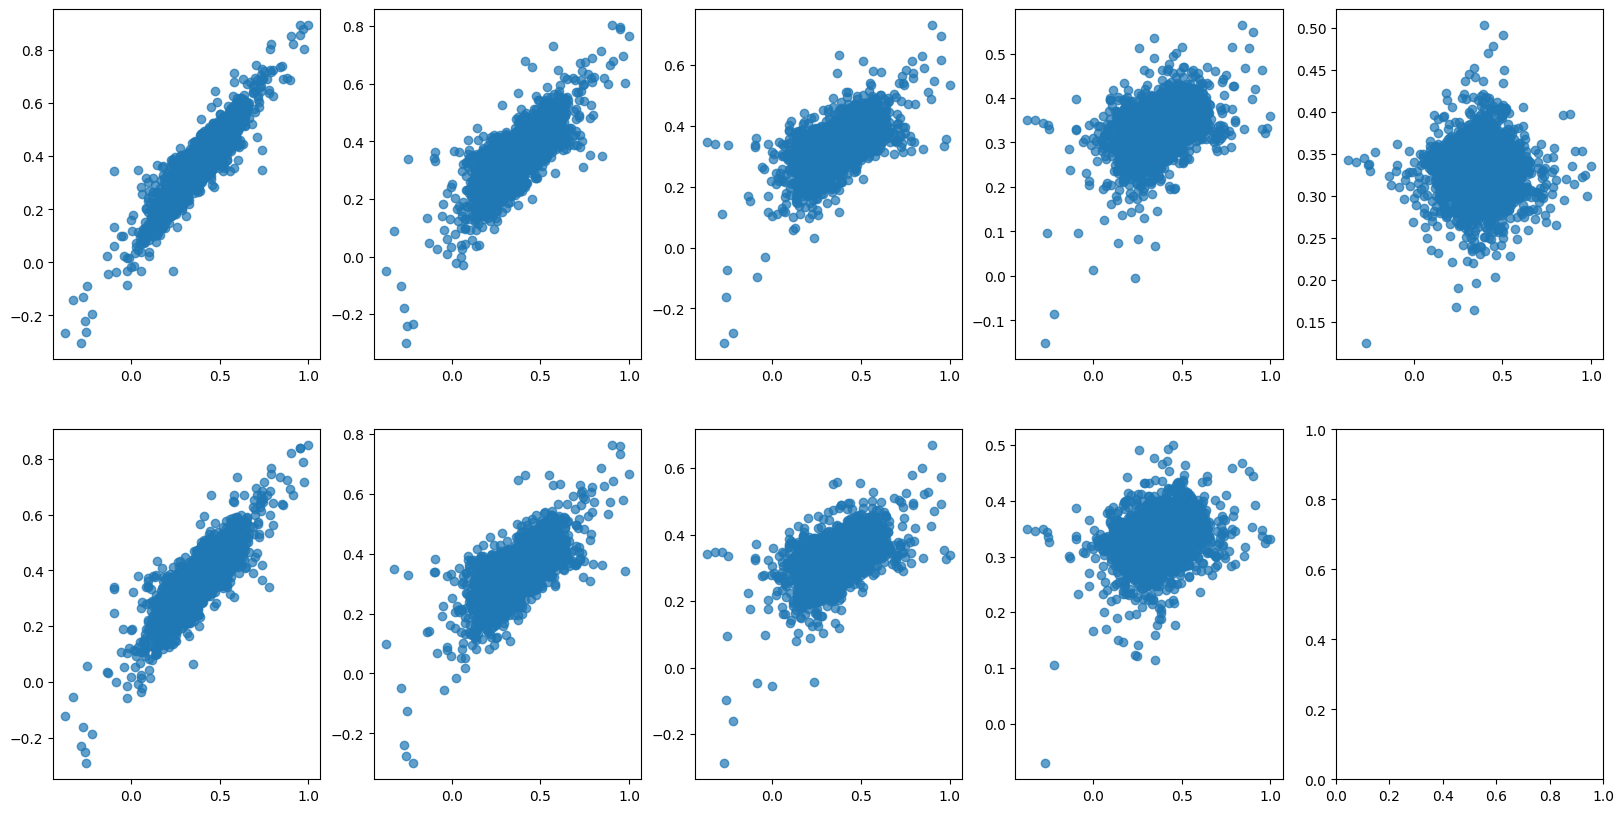

In [189]:
fig, axs = plt.subplots(2, int(prediction_length/2), figsize=(20, 10))
for index in range(0, prediction_length-1):
    # ignore first step as it is last observation
    step = index + 1
    x = index % 2
    y = int(index / 2)
    ax = axs[x, y]
    ax.scatter(close_ans_tokens[step, :], close_pre_tokens[step, :], alpha=0.7)
fig.show()

[]

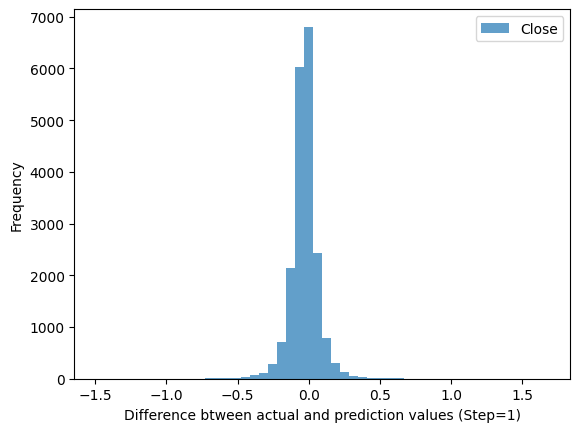

In [61]:
step=1
plt.hist(close_pre[step, :] - close_ans[step, :], bins=50, alpha=0.7)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(["Close"])
plt.plot()

[]

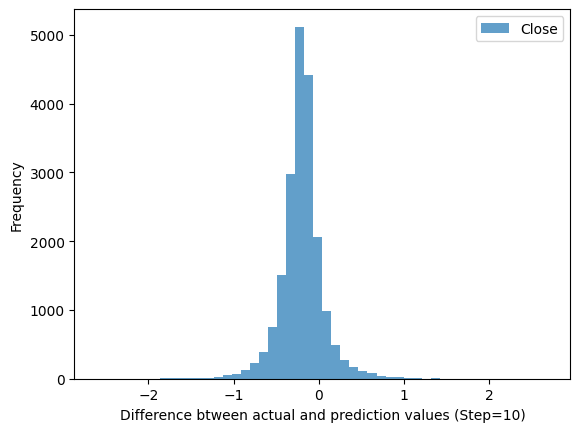

In [62]:
step=prediction_length
plt.hist(close_pre[step, :] - close_ans[step, :], bins=50, alpha=0.7)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(["Close"])
plt.plot()

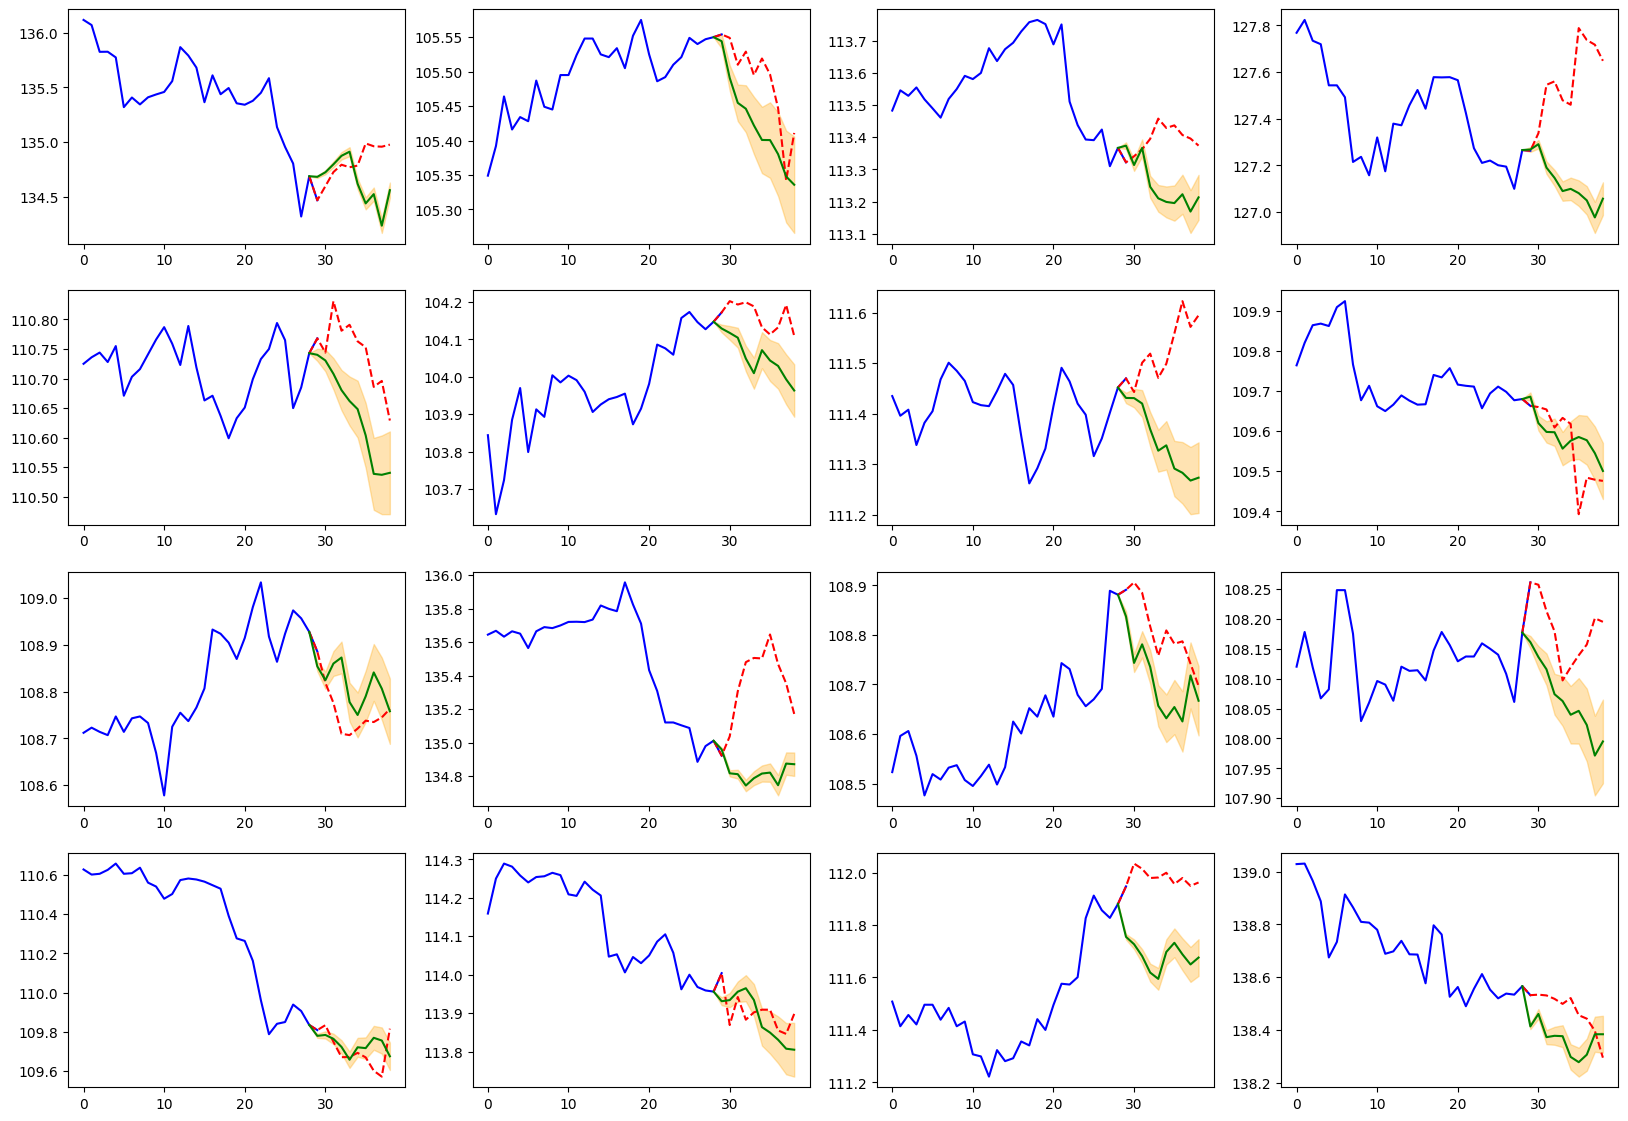

In [187]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(close_pre[:, :, 0]-close_ans[:, :, 0], axis=1)
close_var = np.var(close_pre[:, :, 0]-close_ans[:, :, 0], axis=1)

total_length = observation_length + prediction_length-1
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i) + 10#add periods
    original_close = ds.org_data[close_column].iloc[index: index + observation_length]
    # original_answer = ds.org_data[close_column].iloc[index + observation_length -2: index + observation_length + prediction_length-1]
    pred_value = close_pre[:, i, 0]
    pred_upper = pred_value + close_var
    pred_lower = pred_value - close_var

    ax.fill_between(x[observation_length -2:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_close, color="blue")
    # ax.plot(x[observation_length-2:], original_answer, color="red", linestyle="--")
    ax.plot(x[observation_length-2:], close_ans[:, i, 0], color="red", linestyle="--")
    ax.plot(x[observation_length-2:], pred_value, color="green")
plt.show()

# Another BaseLine Transformer model with weekly position

## Prepare Data

In [2]:
import os
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')

In [3]:
import pandas as pd
df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


In [4]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from tqdm import tqdm

In [5]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.base import TimeDataset
from fprocess import fprocess

In [11]:
import random

class TimeMonoDataset(TimeDataset):    
    key = "tclose"
    
    def __init__(self, df, processes, column:str = "close", time_column="index", data_length=30, observation_length: int = 30,
                 device="cuda", prediction_length=10, seed=1017, is_training=True, randomize=True):
        self.data_length = data_length
        super().__init__(df, [column], processes, time_column, observation_length, device, prediction_length, seed, is_training, randomize)
        self._columns = column
                
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size                
            chunk_tgt = []
            chunk_time = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                future_tgt = []
                time_tgt = []
                # -1 for shift
                for bias in range(-1, self._prediction_length):
                    start_index = index + self.observation_length - self.data_length  + bias
                    stop_index = index + self.observation_length + bias
                    step_ndx = slice(start_index, stop_index)
                    future_tgt.append(self._data[self._columns].iloc[step_ndx].values.tolist())
                    # assume time value is id
                    time_tgt.append(self._data[self.time_column].iloc[stop_index-1].tolist())
                chunk_tgt.append(future_tgt)
                chunk_time.append(time_tgt)
            
            return (
                torch.tensor(chunk_tgt, device=self.device, dtype=torch.float).transpose(0, 1),
                torch.tensor(chunk_time, device=self.device, dtype=torch.int).transpose(0, 1)
            )
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size
            chunk_src = []
            time_chunk_src = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                obs_src = []
                time_src = []
                for bias in range(self.observation_length):
                    stop_index = index + bias
                    obs_ndx = slice(index - self.data_length + bias, stop_index)
                    obs_src.append(self._data[self._columns].iloc[obs_ndx].values.tolist())
                    time_src.append(self._data[self.time_column].iloc[stop_index-1].tolist())
                chunk_src.append(obs_src)
                time_chunk_src.append(time_src)
        
            return (
                torch.tensor(chunk_src, device=self.device, dtype=torch.float).transpose(0, 1),
                torch.tensor(time_chunk_src, device=self.device, dtype=torch.int).transpose(0, 1)
            )
           
    def get_row_data(self, ndx):
        inputs = []
        # return (data_length + observation_length). It represents entire input data of (observation_length, data_length) shape
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self._data[index - self.data_length: index + self.observation_length]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self._data[index -self.data_length: index + self.observation_length]
        return inputs

    def _init_indicies(self, data, randomize, split_ratio=0.7):
        length = len(data) - self.observation_length -self.data_length - self._prediction_length
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        from_index = self.data_length + 1#avoid diff nan
        to_index = int(length*split_ratio)
        self.train_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        from_index = int(length*split_ratio) + self.observation_length + self.data_length + self._prediction_length
        to_index = length
        self.val_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True
    
    def revert_prediction(self, values, ndx):
        r_data = values
        indices = self.get_actual_index(ndx)
        tgt_indices = []
        for __index in indices:
            start_index = __index + self.observation_length -2
            tgt_indices.append(start_index)
        indices = tgt_indices
        for p_index in range(len(self.processes)):
            r_index = len(self.processes) - 1 - p_index
            process = self.processes[r_index]
            params = process.revert_params
            if len(params) == 1:
                r_data = process.revert(r_data)
            else:
                params = {}
                if process.kinds == fprocess.MinMaxPreProcess.kinds:
                    r_data = process.revert(r_data)
                elif process.kinds == fprocess.SimpleColumnDiffPreProcess.kinds:
                    close_column = process.base_column
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [1]
                        base_processes = []
                        for base_process in processes:
                            if close_column in base_process.columns:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            raise Exception("Not implemented yet")
                    base_indices = [index - 1 for index in indices]
                    base_values = self.org_data[close_column].iloc[base_indices]
                    r_data = process.revert(r_data, base_value=base_values)
                elif process.kinds == fprocess.DiffPreProcess.kinds:
                    target_columns = process.columns
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [process.get_minimum_required_length()]
                        base_processes = []
                        for base_process in processes:
                            if len(set(target_columns) & set(base_process.columns)) > 0:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            required_length = max(required_length)
                            batch_base_indices = [index - required_length for index in indices]
                            batch_base_values = pd.DataFrame()
                            for index in batch_base_indices:
                                target_data = self.org_data[target_columns].iloc[index : index + required_length]
                                for base_process in base_processes:
                                    target_data = base_process(target_data)
                                batch_base_values = pd.concat([batch_base_values, target_data.iloc[-1:]], axis=0)
                            batch_base_values = batch_base_values.values.reshape(1, *batch_base_values.shape)
                        else:
                            base_indices = [index - 1 for index in indices]
                            batch_base_values = self.org_data[target_columns].iloc[base_indices]
                    else:
                        base_indices = [index - 1 for index in indices]
                        batch_base_values = self.org_data[target_columns].iloc[base_indices]
                    r_data = process.revert(r_data, base_values=batch_base_values)
                else:
                    raise Exception(f"Not implemented: {process.kinds}")
        return r_data

In [19]:
close_column = "close"
device="cuda:1"
columns = [close_column]

log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column="index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = TimeMonoDataset(df, processes=processes, column=close_column, device=device)

In [17]:
print(len(ds))

for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    break
    
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

70424
torch.Size([30, 16, 30]) torch.Size([30, 16])
torch.Size([11, 16, 30]) torch.Size([11, 16])


In [21]:
test_time_emb = nn.Embedding(24*2*7, 30, device=device)
test_time_src = test_time_emb(src[1])
test_time_src.shape

torch.Size([30, 16, 30])

## Define Model

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [23]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int, time_size:int=24*2*7,
        d_model=30, dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8,
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        self.positional_encoding = PositionalEncoding(time_size, d_model)
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        # src/tgt is not id, so predict last value instead of softmax
        self.output = nn.Linear(d_model, 1)

    def forward(
        self, src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

In [24]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_tgt_time = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [25]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_tgt_time = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [34]:
from torch.utils.data import DataLoader

batch_size = 64
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
d_model = 30
observation_length = 30
prediction_length = 10
close_column = "close"
columns = [close_column]

log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column="index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = TimeMonoDataset(df, column=close_column, time_column="index", data_length=d_model, device=device,
                     observation_length=observation_length, prediction_length=prediction_length, processes=processes)

In [27]:
model_name = "finance_basic_close_wt_transformer"
model_version = 1

In [28]:
feature_size = 1
d_model=30
nhead = 5
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01
time_size = 24*2*7

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model=d_model,
    time_size=time_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [30]:
lr = 1e-4

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

In [ ]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

# No overlap

In [41]:
import os
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')

In [42]:
import pandas as pd
df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


In [43]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from tqdm import tqdm

## Define Dataset

In [45]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.base import TimeDataset
from fprocess import fprocess

In [ ]:
import random

class TimeMonoDataset(TimeDataset):
    key = "close"        
    
    def __init__(self, df, processes, column="close", time_column="index", observation_length: int = 60,data_length=30, device="cuda", prediction_length=10, seed=1017, is_training=True, randomize=True):
        self.data_length = data_length
        super().__init__(df, [column], processes, time_column, observation_length, device, prediction_length, seed, is_training, randomize)
        self._columns = column

                
    def _output_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size                
            chunk_tgt = []
            chunk_time = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                future_tgt = []
                time_tgt = []
                index += self.observation_length * self.data_length
                for bias in range(-1, self._prediction_length*self.data_length, self.data_length):
                    start_index = index - self.data_length + bias
                    stop_index = index + bias
                    step_ndx = slice(start_index, stop_index)
                    future_tgt.append(self._data[self._columns].iloc[step_ndx].values.tolist())
                    time_tgt.append(self._data[self.time_column].iloc[stop_index-1].tolist())
                chunk_tgt.append(future_tgt)
                chunk_time.append(time_tgt)
            
            return (
                torch.tensor(chunk_tgt, device=self.device, dtype=torch.float).transpose(0, 1),
                torch.tensor(chunk_time, device=self.device, dtype=torch.int).transpose(0, 1)
            )
    
    def _input_func(self, batch_size):
        if type(batch_size) == int:
            pass
        elif type(batch_size) == slice:
            batch_indices = batch_size
            chunk_src = []
            time_chunk_src = []
            ndx = self._indices[batch_indices]
            
            for index in ndx:
                obs_src = []
                time_tgt = []
                for bias in range(0, self.observation_length*self.data_length, self.data_length):
                    start_index = index - self.data_length + bias
                    stop_index = index + bias
                    obs_ndx = slice(start_index, stop_index)
                    obs_src.append(self._data[self._columns].iloc[obs_ndx].values.tolist())
                    time_tgt.append(self._data[self.time_column].iloc[stop_index-1].tolist())
                chunk_src.append(obs_src)
                time_chunk_src.append(time_tgt)
        
            return (
                torch.tensor(chunk_src, device=self.device, dtype=torch.float).transpose(0, 1),
                torch.tensor(time_chunk_src, device=self.device, dtype=torch.int).transpose(0, 1)
            )
           
    def get_row_data(self, ndx):
        inputs = []
        # return (data_length + observation_length). It represents entire input data of (observation_length, data_length) shape
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self._data[index - self.data_length: index + self.observation_length]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self._data[index -self.data_length: index + self.observation_length]
        return inputs

    def _init_indicies(self, data, randomize, split_ratio=0.7):        
        from_index = self.data_length
        total_indices = [*range(self.data_length, len(data), self.data_length)]
        length = len(total_indices[:-(self._prediction_length + self.observation_length)])
        
        from_index = 0
        to_index = int(length*split_ratio)
        self.train_indices = [
            total_indices[index] for index in 
            random.sample(range(from_index, to_index), k=to_index - from_index)
        ]
        
        from_index = int(length*split_ratio) + self._prediction_length
        to_index = length
        self.val_indices = [
            total_indices[index] for index in
            random.sample(range(from_index, to_index), k=to_index - from_index)
        ]
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True
    
    def revert_prediction(self, values, ndx):
        r_data = values
        indices = self.get_actual_index(ndx)
        tgt_indices = []
        for __index in indices:
            start_index = __index + self.observation_length -2
            tgt_indices.append(start_index)
        indices = tgt_indices
        for p_index in range(len(self.processes)):
            r_index = len(self.processes) - 1 - p_index
            process = self.processes[r_index]
            params = process.revert_params
            if len(params) == 1:
                r_data = process.revert(r_data)
            else:
                params = {}
                if process.kinds == fprocess.MinMaxPreProcess.kinds:
                    r_data = process.revert(r_data)
                elif process.kinds == fprocess.SimpleColumnDiffPreProcess.kinds:
                    close_column = process.base_column
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [1]
                        base_processes = []
                        for base_process in processes:
                            if close_column in base_process.columns:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            raise Exception("Not implemented yet")
                    base_indices = [index - 1 for index in indices]
                    base_values = self.org_data[close_column].iloc[base_indices]
                    r_data = process.revert(r_data, base_value=base_values)
                elif process.kinds == fprocess.DiffPreProcess.kinds:
                    target_columns = process.columns
                    if p_index > 0:
                        processes = self.processes[:p_index]
                        required_length = [process.get_minimum_required_length()]
                        base_processes = []
                        for base_process in processes:
                            if len(set(target_columns) & set(base_process.columns)) > 0:
                                base_processes.append(base_process)
                                required_length.append(base_process.get_minimum_required_length())
                        if len(base_processes) > 0:
                            required_length = max(required_length)
                            batch_base_indices = [index - required_length for index in indices]
                            batch_base_values = pd.DataFrame()
                            for index in batch_base_indices:
                                target_data = self.org_data[target_columns].iloc[index : index + required_length]
                                for base_process in base_processes:
                                    target_data = base_process(target_data)
                                batch_base_values = pd.concat([batch_base_values, target_data.iloc[-1:]], axis=0)
                            batch_base_values = batch_base_values.values.reshape(1, *batch_base_values.shape)
                        else:
                            base_indices = [index - 1 for index in indices]
                            batch_base_values = self.org_data[target_columns].iloc[base_indices]
                    else:
                        base_indices = [index - 1 for index in indices]
                        batch_base_values = self.org_data[target_columns].iloc[base_indices]
                    r_data = process.revert(r_data, base_values=batch_base_values)
                else:
                    raise Exception(f"Not implemented: {process.kinds}")
        return r_data

In [99]:
close_column = "close"
device="cuda:1"
columns = [close_column]

log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column="index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = TimeMonoDataset(df, processes=processes, column=close_column, time_column="index", device=device)

In [102]:
ds.train()
for index in tqdm(range(0, len(ds), 16)):
    src, tgt = ds[index:index+16]
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

100%|██████████| 144/144 [00:14<00:00, 10.08it/s]

torch.Size([60, 12, 30]) torch.Size([60, 12])
torch.Size([11, 12, 30]) torch.Size([11, 12])


In [100]:
ds.eval()
for index in tqdm(range(0, len(ds), 16)):
    src, tgt = ds[index:index+16]
print(src[0].shape, src[1].shape)
print(tgt[0].shape, tgt[1].shape)

100%|██████████| 62/62 [00:07<00:00,  8.56it/s]

torch.Size([60, 1, 30]) torch.Size([60, 1])
torch.Size([11, 1, 30]) torch.Size([11, 1])


## Define Model

In [50]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [51]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int, time_size:int=24*2*7,
        d_model=30, dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8,
    ):
        
        super(Seq2SeqTransformer, self).__init__()
        self.positional_encoding = PositionalEncoding(time_size, d_model)
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        # src/tgt is not id, so predict last value instead of softmax
        self.output = nn.Linear(d_model, 1)

    def forward(
        self, src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

In [52]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_tgt_time = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [53]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt

        input_tgt = tgt[:-1, :]
        input_tgt_time = tgt_time[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :, -1:]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Train Model

In [62]:
from torch.utils.data import DataLoader

batch_size = 64
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
d_model = 30
observation_length = 30
prediction_length = 10
close_column = "close"
columns = [close_column]

log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns)
time_p = fprocess.WeeklyIDProcess(freq=30, time_column="index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

ds = TimeMonoDataset(df, column=close_column, time_column="index", data_length=d_model, device=device,
                     observation_length=observation_length, prediction_length=prediction_length, processes=processes)

In [63]:
model_name = "finance_basic_close_wt_transformer"
model_version = 2

In [64]:
feature_size = 1
d_model=30
nhead = 5
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01
time_size = 24*2*7

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_model=d_model,
    time_size=time_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [65]:
lr = 1e-4

#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [104]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████| 35/35 [00:15<00:00,  2.20it/s]


[1/500] train loss: 0.0029091593, valid loss: 0.0018463213  [16s] count: 0, **


100%|██████████| 35/35 [00:16<00:00,  2.09it/s]


[2/500] train loss: 0.0029234574, valid loss: 0.0018581931  [17s] count: 0, 


100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


[3/500] train loss: 0.0028781193, valid loss: 0.0018430338  [16s] count: 1, **


100%|██████████| 35/35 [00:15<00:00,  2.22it/s]


[4/500] train loss: 0.0029127654, valid loss: 0.0018536253  [16s] count: 0, 


100%|██████████| 35/35 [00:15<00:00,  2.28it/s]


[5/500] train loss: 0.0028627409, valid loss: 0.0018563019  [15s] count: 1, 


100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


[6/500] train loss: 0.0028193659, valid loss: 0.0018614194  [16s] count: 2, 


100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


[7/500] train loss: 0.0027842075, valid loss: 0.0018519653  [16s] count: 3, 


100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


[8/500] train loss: 0.0028192462, valid loss: 0.0018541956  [15s] count: 4, 


100%|██████████| 35/35 [00:16<00:00,  2.19it/s]


[9/500] train loss: 0.0028044231, valid loss: 0.0018617103  [16s] count: 5, 


100%|██████████| 35/35 [00:15<00:00,  2.26it/s]


[10/500] train loss: 0.0027908524, valid loss: 0.0018510786  [16s] count: 6, 


100%|██████████| 35/35 [00:15<00:00,  2.28it/s]


[11/500] train loss: 0.0027824362, valid loss: 0.0018593624  [15s] count: 7, 


100%|██████████| 35/35 [00:15<00:00,  2.19it/s]


[12/500] train loss: 0.0027656816, valid loss: 0.0018707178  [16s] count: 8, 


100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


[13/500] train loss: 0.0027485560, valid loss: 0.0018495252  [16s] count: 9, 


100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


[14/500] train loss: 0.0027497794, valid loss: 0.0018652219  [15s] count: 10, 


In [105]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')